In [26]:
#importing some models. Going to use tensorflow for modelling
#nltk contains list of stopwords to remove
#also import seaborn for plotting

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import nltk
import re
import tensorflow_hub as hub
import random




#some useful packages from natural language toolkit
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer




from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.math import confusion_matrix

#this is a trick to make the plots look better in dark mode
plt.style.use('dark_background')
sns.set_palette('bright')

random.seed(10)



In [27]:
#list of contractions 
#https://gist.github.com/nealrs/96342d8231b75cf4bb82/revisions with some changes


import re
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

def expandContractions(text,cList=cList):
    for word, replacement in cList.items():
        text = text.replace(word.lower(), replacement)
    return text


In [28]:
#import datasets. Also make seperate datasets for disaster and no disaster for EDA


#use when running on cloud to fetch datasets
#!wget 'https://raw.githubusercontent.com/LRozeboom/nlp_disaster/master/test.csv'
#!wget 'https://raw.githubusercontent.com/LRozeboom/nlp_disaster/master/train.csv'

df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

disaster=df_train[df_train['target']==1]
nodisaster=df_train[df_train['target']==0]
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [29]:
#look at some differences between disaster and nodisaster tweets
#first calculate some text properties for plotting


def avg_wordlength(sentence):
    words = sentence.split()
    average = sum(len(word) for word in words) / len(words)
    return average

def num_chars(sentence):
    return len(sentence)

def word_count(sentence):
    return len(str(sentence).split())

def hashtag_count(sentence):
    return sentence.count('#')

def at_count(sentence):
    return sentence.count('@')


#apply these functions to the dataframes for distaster and nodisaster

disaster['avg_wordlen']=disaster['text'].apply(lambda x: avg_wordlength(x))
nodisaster['avg_wordlen']=nodisaster['text'].apply(lambda x: avg_wordlength(x))

disaster['num_chars']=disaster['text'].apply(lambda x: num_chars(x))
nodisaster['num_chars']=nodisaster['text'].apply(lambda x: num_chars(x))

disaster['word_count']=disaster['text'].apply(lambda x: word_count(x))
nodisaster['word_count']=nodisaster['text'].apply(lambda x: word_count(x))

disaster['hashtag_count']=disaster['text'].apply(lambda x: hashtag_count(x))
nodisaster['hashtag_count']=nodisaster['text'].apply(lambda x: hashtag_count(x))

disaster['at_count']=disaster['text'].apply(lambda x: at_count(x))
nodisaster['at_count']=nodisaster['text'].apply(lambda x: at_count(x))

disaster.head()






C:\Users\lrozebo1\AppData\Local\Temp\ipykernel_17372\2062797363.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disaster['avg_wordlen']=disaster['text'].apply(lambda x: avg_wordlength(x))
C:\Users\lrozebo1\AppData\Local\Temp\ipykernel_17372\2062797363.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodisaster['avg_wordlen']=nodisaster['text'].apply(lambda x: avg_wordlength(x))
C:\Users\lrozebo1\AppData\Local\Temp\ipykernel_17372\2062797363.py:28: SettingWithCopyWarning: 
A value is trying to be se

,id,keyword,location,text,target,avg_wordlen,num_chars,word_count,hashtag_count,at_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,4.384615,69,13,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,4.571429,38,7,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,5.090909,133,22,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,7.125000,65,8,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,4.500000,88,16,2,0


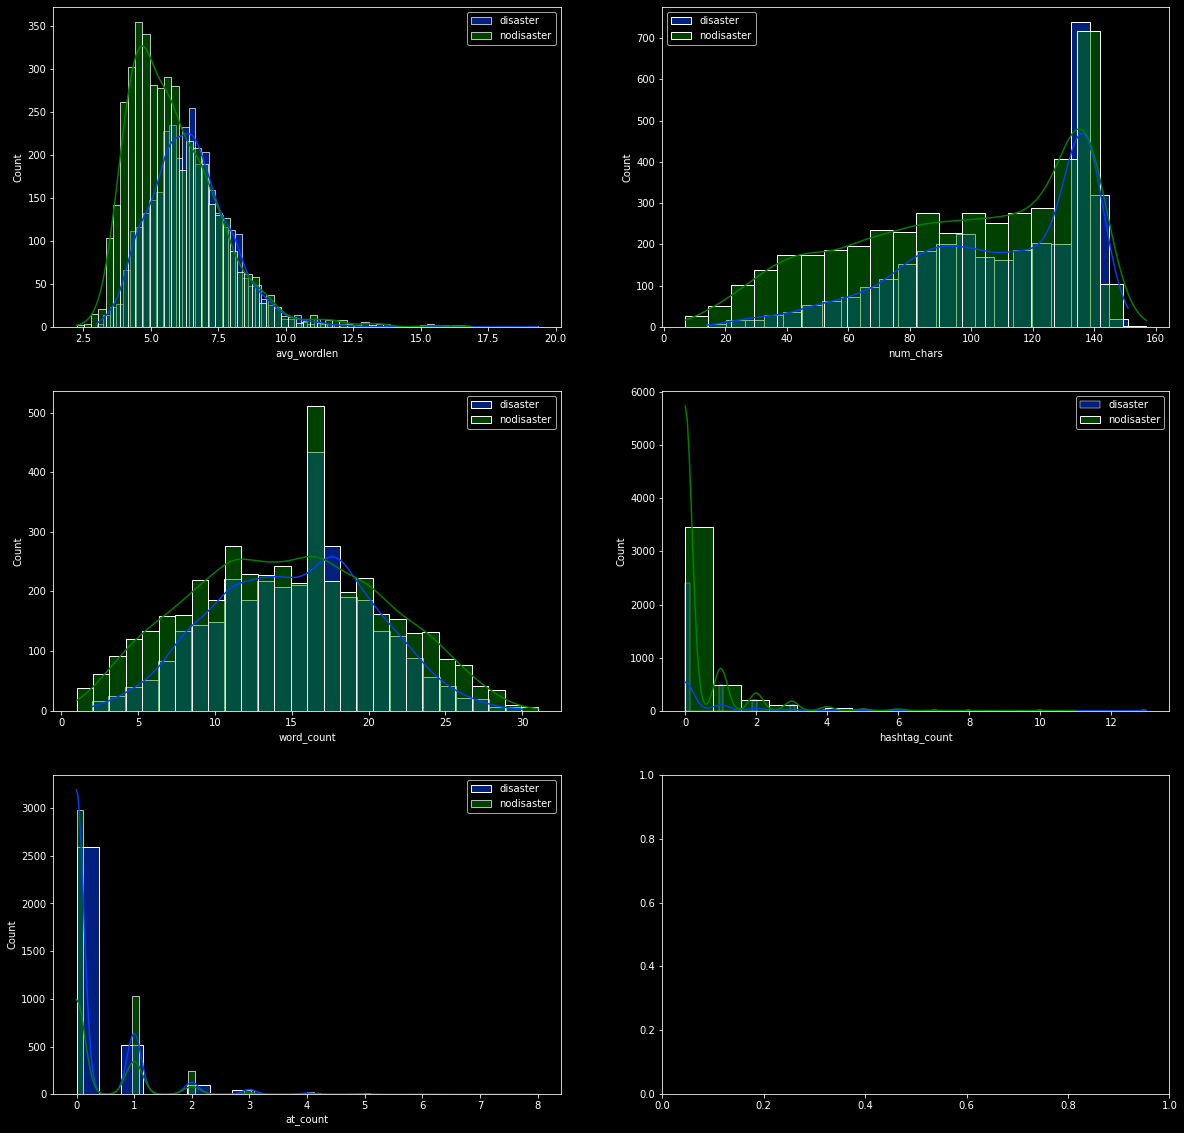

In [30]:
#now compare these values for disaster and non-disaster tweets


fig,axes=plt.subplots(3,2,figsize=(20,20))

sns.histplot(disaster['avg_wordlen'] ,label='disaster',ax=axes[0,0],kde=True)
sns.histplot(nodisaster['avg_wordlen'],label='nodisaster',ax=axes[0,0],kde=True,color='green')
axes[0,0].legend()

sns.histplot(disaster['num_chars'] ,label='disaster',ax=axes[0,1],kde=True)
sns.histplot(nodisaster['num_chars'],label='nodisaster',ax=axes[0,1],kde=True,color='green')
axes[0,1].legend()

sns.histplot(disaster['word_count'] ,label='disaster',ax=axes[1,0],kde=True)
sns.histplot(nodisaster['word_count'],label='nodisaster',ax=axes[1,0],kde=True,color='green')
axes[1,0].legend()


sns.histplot(disaster['hashtag_count'] ,label='disaster',ax=axes[1,1],kde=True)
sns.histplot(nodisaster['hashtag_count'],label='nodisaster',ax=axes[1,1],kde=True,color='green')
axes[1,1].legend()

sns.histplot(disaster['at_count'] ,label='disaster',ax=axes[2,0],kde=True)
sns.histplot(nodisaster['at_count'],label='nodisaster',ax=axes[2,0],kde=True,color='green')
axes[2,0].legend()

In [31]:
#look at different keywords, display average target value

df_train.groupby('keyword').mean()


,id,target
keyword,,
ablaze,70.388889,0.361111
accident,121.800000,0.685714
aftershock,171.323529,0.000000
airplane%20accident,220.142857,0.857143
ambulance,269.052632,0.526316
...,...,...
wounded,10609.135135,0.702703
wounds,10662.393939,0.303030
wreck,10708.513514,0.189189


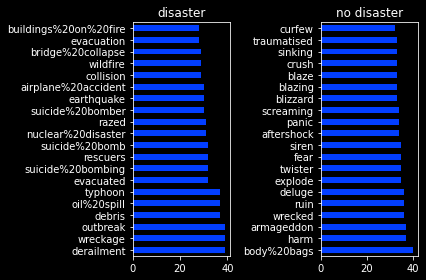

In [32]:
#keyword distribution for disaster and non-disaster
disaster_keywordcounts=disaster['keyword'].value_counts()
nodisaster_keywordcounts=nodisaster['keyword'].value_counts()

#barplot of most frequent keywords for disaster and no-disaster
fig,ax=plt.subplots(1,2)
disaster_keywordcounts[:20].plot.barh(ax=ax[0])
ax[0].set_title('disaster')
nodisaster_keywordcounts[:20].plot.barh(ax=ax[1])
ax[1].set_title('no disaster')

fig.tight_layout()
#plt.figure()
#sns.distplot(disaster_keywordcounts)
#sns.distplot(nodisaster_keywordcounts)


In [33]:
#look how many empty columns we have
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [34]:
#count number of disasters and nodisasters in training set
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [35]:
#put everything to lower case, remove #, @ and ' from tweets.
#found out this was built into tokenizer


df_train['text_clean'] = df_train['text'].apply(lambda x: x.lower())
# df_train['text_clean'] = df_train['text_clean'].str.replace('#','')
# df_train['text_clean'] = df_train['text_clean'].str.replace('@','')

# df_train['text_clean'] = df_train['text_clean'].str.replace('?','')
# df_train['text_clean'] = df_train['text_clean'].str.replace('!','')
# df_train['text_clean'] = df_train['text_clean'].str.replace('=>','')
# df_train['text_clean'] = df_train['text_clean'].str.replace('-','')
# df_train['text_clean'] = df_train['text_clean'].str.replace(',','')
# df_train['text_clean'] = df_train['text_clean'].str.replace(':','')
# df_train['text_clean'] = df_train['text_clean'].str.replace(';','')
# df_train['text_clean'] = df_train['text_clean'].str.replace(')','')
# df_train['text_clean'] = df_train['text_clean'].str.replace('(','')

#removing some nonsense from dictionary. There are many more, but here are the most common ones

df_train['text_clean'] = df_train['text_clean'].str.replace('\x89û','')
df_train['text_clean'] = df_train['text_clean'].str.replace('\x89ûò','')
df_train['text_clean'] = df_train['text_clean'].str.replace('\x89ûó','')
df_train['text_clean'] = df_train['text_clean'].str.replace('\x89ûï','')



#remove numbers
df_train['text_clean'] = df_train['text_clean'].str.replace('\d+', '')
    

#remove urls from tweets
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

df_train['text_clean']=df_train['text_clean'].apply(lambda x: remove_url(x))


#expand some common contractions using custom code

df_train['text_clean']=df_train['text_clean'].apply(lambda x: expandContractions(x))


#removing quotation marks as they are not removed by the tensorflow tokenizer by default
df_train['text_clean'] = df_train['text_clean'].str.replace('\'','')

df_train.head(30)

C:\Users\lrozebo1\AppData\Local\Temp\ipykernel_17372\4043398922.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['text_clean'] = df_train['text_clean'].str.replace('\d+', '')


,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#rockyfire update => california hwy. closed i...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,#flood #disaster heavy rain causes flash flood...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,i am on top of the hill and i can see a fire i...
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,there is an emergency evacuation happening now...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,i am afraid that the tornado is coming to our ...


In [36]:
#train/validation split

xtrain, xval, ytrain, yval=train_test_split(df_train['text_clean'],df_train['target'])


#remove stopwords from train set, this will make these words out of vocabulary
#create list of stopwords to remove

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

xtrain = [' '.join([y for y in x.split() if y not in stop_words]) for x in xtrain]
xtrain[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lrozebo1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['get hazard pay',
 'new games coming soon @breachgamingorg ?',
 'tiffanyfrizzell crush:',
 '@kristindavis @un @refugees thank @un @refugees helping many people need world.... _',
 'youth electrocuted khulna | via @sharethis',
 'someone: mentions gansey fire busting brick walls seven different buildings:',
 '@tonymcguinness probably inundated question coming creamfields??? (please say ) #mainstage',
 'lindenow: :pm emergency crews chemical spill main street near church street',
 'daviesmutia: breaking news! unconfirmed! heard loud bang nearby. appears blast wind neighbours ass.',
 'catastrophic-fallen-angel: reveillertm: macabrelolita: supposed write ÷amino acidsª nearly...']

In [37]:
#defining some variables, making it easier to tune them later

vocab_size = 20000
embedding_dim = 32
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

<AxesSubplot:>

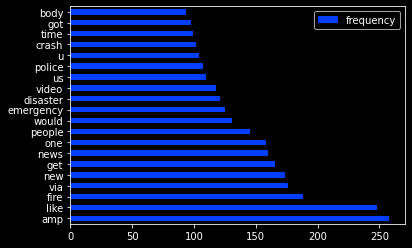

In [38]:
#create tokenizer object and fit on text
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)


tokenizer.fit_on_texts(xtrain)
wordcounts=tokenizer.word_counts



#word count to dataframe for visualization
df=pd.DataFrame(wordcounts.values(),index=wordcounts.keys(),columns=['frequency'])

for i in stop_words:
    for j in df.index:
        if i == j:
            df.drop(i, inplace=True)

sorteddf=df.sort_values(by=['frequency'],ascending=False)[0:20]


sorteddf.plot.barh()

In [39]:
tokenizer.word_index

{'<OOV>': 1,
 'amp': 2,
 'like': 3,
 'fire': 4,
 'via': 5,
 'new': 6,
 'get': 7,
 'news': 8,
 'one': 9,
 'people': 10,
 'would': 11,
 'emergency': 12,
 'disaster': 13,
 'video': 14,
 'us': 15,
 'police': 16,
 'u': 17,
 'crash': 18,
 'time': 19,
 'got': 20,
 'body': 21,
 'know': 22,
 'suicide': 23,
 'day': 24,
 'still': 25,
 'california': 26,
 'storm': 27,
 'burning': 28,
 'gt': 29,
 'man': 30,
 'nuclear': 31,
 'bomb': 32,
 'rt': 33,
 'see': 34,
 'world': 35,
 'going': 36,
 'back': 37,
 'w': 38,
 'first': 39,
 'buildings': 40,
 'cannot': 41,
 'love': 42,
 'killed': 43,
 'dead': 44,
 'life': 45,
 'train': 46,
 'families': 47,
 'go': 48,
 'attack': 49,
 'fires': 50,
 'full': 51,
 'old': 52,
 'car': 53,
 'may': 54,
 'year': 55,
 'accident': 56,
 'two': 57,
 'today': 58,
 'youtube': 59,
 'war': 60,
 'say': 61,
 'pm': 62,
 'hiroshima': 63,
 's': 64,
 'good': 65,
 'many': 66,
 'a': 67,
 'last': 68,
 'collapse': 69,
 'army': 70,
 'watch': 71,
 'could': 72,
 'need': 73,
 'death': 74,
 'years': 

In [40]:
# #we can also do this for disaster/nodisaster seperately to plot the differences

# tokenizer_nodisaster=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
# tokenizer_nodisaster.fit_on_texts(nodisaster)
# wordcounts_nodisaster=tokenizer_nodisaster.word_counts
# series_nodisaster_wordcounts=pd.DataFrame(wordcounts_nodisaster.values(),index=wordcounts_nodisaster.keys())
# for i in stop_words:
#     for j in df.index:
#         if i == j:
#             series_nodisaster_wordcounts.drop(i, inplace=True)

# #same for disasters

# tokenizer_disaster=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
# tokenizer_disaster.fit_on_texts(disaster[''])
# wordcounts_disaster=tokenizer_disaster.word_counts
# series_disaster_wordcounts=pd.DataFrame(wordcounts_disaster.values(),index=wordcounts_disaster.keys())
# for i in stop_words:
#     for j in df.index:
#         if i == j:
#             series_disaster_wordcounts.drop(i, inplace=True)


In [41]:
#ceate sequences and pad sequences
train_seq=tokenizer.texts_to_sequences(xtrain)
train_padded=pad_sequences(train_seq,maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_seq=tokenizer.texts_to_sequences(xval)
val_padded=pad_sequences(val_seq,maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_padded[3]


array([   1,    1, 4457,    1,    1,    1,    1,    1,  816, 2288, 4436,
       7992, 3258,  437,  293,  321,  222,    3,   67,    1,    1,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [53]:
#bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)
#bert_layer=hub.KerasLayer(module_url, trainable=True, name='BERT')
#bert_preprocessing=hub.KerasLayer(tfhub_handle_preprocess, trainable=True, name='vectorizing')

model=tf.keras.Sequential([
     tf.keras.layers.Embedding(input_dim=vocab_size,output_dim= embedding_dim,input_length=max_length,mask_zero=True),
     tf.keras.layers.SpatialDropout1D(0.2),
     tf.keras.layers.Conv1D(32, kernel_size= 3, padding="same"),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.MaxPooling1D(2),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(embedding_dim, activation='relu'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.1,return_sequences=True)),
     tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, dropout=0.1,return_sequences=True)),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(8, activation='relu'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(1,activation="sigmoid")
 ])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 32)           640000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 32)           3104      
                                                                 
 batch_normalization_1 (Batc  (None, 200, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                      

In [54]:
num_epochs = 5
history = model.fit(train_padded, ytrain, epochs=num_epochs, validation_data=(val_padded, yval), verbose=2)

yhat=model.predict(val_padded)

ypred=[1 if val>0.5 else 0 for val in yhat ]
print(confusion_matrix(yval,ypred))


plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

Epoch 1/5


KeyboardInterrupt: 

In [47]:
#now apply the moddel to predict wether a sentence is about a disaster


df_test['text_clean'] = df_test['text'].apply(lambda x: x.lower())
# df_test['text_clean'] = df_test['text_clean'].str.replace('#','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('@','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('\d+', '')
# df_test['text_clean'] = df_test['text_clean'].str.replace('\'','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('?','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('!','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('=>','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('-','')
# df_test['text_clean'] = df_test['text_clean'].str.replace(',','')
# df_test['text_clean'] = df_test['text_clean'].str.replace(':','')
# df_test['text_clean'] = df_test['text_clean'].str.replace(';','')
# df_test['text_clean'] = df_test['text_clean'].str.replace(')','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('(','')


df_test['text_clean']=df_test['text_clean'].apply(lambda x: remove_url(x))
df_test['text_clean']=df_test['text_clean'].apply(lambda x: expandContractions(x))
df_test['text_clean'] = df_test['text_clean'].str.replace('\'','')




sentences=df_test['text_clean']

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

predictions=model.predict(padded)

In [48]:
df_test['prob_disaster']=predictions

df_test['target']=df_test['prob_disaster'].apply(lambda x: 1 if x>0.5 else 0)

df_output=df_test[['id','target']]

In [49]:
df_output.to_csv('output.csv',index=False)

In [50]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [51]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]